# Introduction

This notebook is forked from https://www.kaggle.com/andypenrose/osic-multiple-quantile-regression-starter 


In [ ]:
import numpy as np
import pandas as pd
import pydicom
import os
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold,GroupKFold,TimeSeriesSplit,train_test_split
from time import time

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M

from keras.layers import LSTM, Dropout

In [ ]:
try:
    del z_test
    del y_test
    del pred_test
    print('deleted')
except:
    print('go')

In [ ]:
def seed_everything(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
seed_everything(24)

In [ ]:
ROOT = "../input/osic-pulmonary-fibrosis-progression"

In [ ]:
## evaluation metric function
def laplace_log_likelihood(actual_fvc, predicted_fvc, confidence, return_values = False):
    """
    Calculates the modified Laplace Log Likelihood score for this competition.
    """
    sd_clipped = np.maximum(confidence, 70)
    delta = np.minimum(np.abs(actual_fvc - predicted_fvc), 1000)
    metric = - np.sqrt(2) * delta / sd_clipped - np.log(np.sqrt(2) * sd_clipped)

    if return_values:
        return metric
    else:
        return np.mean(metric)


## default benchmark


In [ ]:
tra = pd.read_csv(f"{ROOT}/train.csv")
tra.drop_duplicates(keep=False, inplace=True, subset=['Patient','Weeks'])
chunk = pd.read_csv(f"{ROOT}/test.csv")

sub = pd.read_csv(f"{ROOT}/sample_submission.csv")
sub['Patient'] = sub['Patient_Week'].apply(lambda x:x.split('_')[0])
sub['Weeks'] = sub['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
sub =  sub[['Patient','Weeks','Confidence','Patient_Week']]
sub = sub.merge(chunk.drop('Weeks', axis=1), on="Patient") # appiccica a sub le colonne di Chunk a parte week


In [ ]:
tra.columns

In [ ]:
'''
tr['Dist'] = 0
tr = tr.sort_values(by=['Patient', 'Weeks'])
for p in range(1,tr.shape[0]):
    if tr.iloc[p, 0] == tr.iloc[p-1, 0]:
        tr.iloc[p, -1] = tr.iloc[p, 2] - tr.iloc[p-1, 2]   
print(tr.iloc[:,-1].describe())
'''

In [ ]:
sub.columns

In [ ]:
'''
sub['Dist'] = 0
sub = sub.sort_values(by=['Patient', 'Weeks'])
for p in range(1,sub.shape[0]):
    if sub.iloc[p, 0] == sub.iloc[p-1, 0]:
        sub.iloc[p, -1] = sub.iloc[p, 4] - sub.iloc[p-1, 4]   
print(sub.iloc[:,-1].describe())
'''


In [ ]:
'''
chunk['Dist'] = 0
'''

trr = pd.DataFrame(tr).copy()
ppp=trr[trr.Patient == 'ID00007637202177411956430'].copy()
ppp['Old'] = True
aaa = ppp.loc[0]
aaa
r = pd.DataFrame([aaa], columns = ppp.columns)
r['Weeks']=0
r['FVC']=0
r['Percent']=0
ppp = pd.concat([ppp, r], ignore_index=True)

In [ ]:
tr = pd.DataFrame(tra).copy()

In [ ]:
'''
# devo creare le righe mancanti

pat = tr['Patient'][0]
for pat in tr['Patient'].unique():
    k=0
    base = tr.loc[tr.Patient == pat]
    baseB = base.values[0]
    baseDf = pd.DataFrame([baseB], columns = base.columns)
    for we in sorted(sub['Weeks'].unique()):
        a = tr.loc[tr['Patient'] == pat] #tutte le week di pat
        b= a.loc[a['Weeks'] == we,'FVC'] #FVC di week we
        if b.unique().size == 0:
            if we == sub['Weeks'].max():
                appoggio = baseDf.copy()
                bb= a.loc[a['Weeks'] == (we-k-1),'FVC']
                bb = bb.values[0]
                delta = 0
                #print('we:',we,' b:',b,' bb',bb,'k:',k,' delta:',delta)
      
                for j in range(1, k+1):
                    appoggio.Weeks = (we-k+j)
                    appoggio.FVC = bb
                    appoggio.Percent = appoggio.FVC / (baseDf.FVC / baseDf.Percent)
                    tr = pd.concat([tr, appoggio], ignore_index=True)
    
                del appoggio
                k=0
            elif we == sub['Weeks'].min():
                appoggio = baseDf.copy()
                appoggio.Weeks = we
                tr = pd.concat([tr, appoggio], ignore_index=True)
                del appoggio
                k=0
            else:
                k = k+1
        elif k > 0:
            appoggio = baseDf.copy()
            bb= a.loc[a['Weeks'] == (we-k-1),'FVC'] 
            if bb.unique().size == 0:
                appoggio.Weeks = (we-k-1)
                appoggio.FVC = b.values[0]
                appoggio.Percent = appoggio.FVC / (baseDf.FVC / baseDf.Percent)
                del bb
                bb = a.loc[a['Weeks'] == we,'FVC']
            
            bb = bb.values[0]
            b = b.values[0]
            delta = b - bb
            #print('we:',we,' b:',b,' bb',bb,'k:',k,' delta:',delta)
  
            for j in range(0, k):
                bbb = bb + delta/(k+1)*(j+1) #ho calcolato FVC nuova riga
                
                appoggio.Weeks = (we-k+j)
                appoggio.FVC = bbb
                appoggio.Percent = appoggio.FVC / (baseDf.FVC / baseDf.Percent)
                
                tr = pd.concat([tr, appoggio], ignore_index=True)
    
            del appoggio
            k=0
    del baseDf,baseB, base, a, b, bb, bbb,
'''

In [ ]:
tr['WHERE'] = 'train'
chunk['WHERE'] = 'val'
sub['WHERE'] = 'test'
data = tr.append([chunk, sub])

In [ ]:
print(tr.shape, chunk.shape, sub.shape, data.shape)
print(tr.Patient.nunique(), chunk.Patient.nunique(), sub.Patient.nunique(), 
      data.Patient.nunique())
#

In [ ]:
'''
voglio associare ad ogni riga:
- aggregando per età/smoking status e sesso
    - i tre percentili del valore massimo
    - i tre percentili del valore minimo
    - i tre percentili del rapporto tra max e min
    f=pd.DataFrame(d.groupby(['a','b']))
'''
data['min_perc'] = data.Percent
data.loc[data.WHERE=='test','min_perc'] = np.nan
data['max_perc'] = data.Percent
data.loc[data.WHERE=='test','max_perc'] = np.nan

data['min_perc'] = data.groupby(['Age','SmokingStatus','Sex'])['Percent'].transform('min')
data['max_perc'] = data.groupby(['Age','SmokingStatus','Sex'])['Percent'].transform('max')

data['rif_perc'] = data.max_perc - data.min_perc
data.loc[data.rif_perc > 0, 'rif_perc']= (data.loc[data.rif_perc > 0, 'Percent']- data.loc[data.rif_perc > 0, 'min_perc'])/\
    (data.loc[data.rif_perc > 0, 'max_perc'] - data.loc[data.rif_perc > 0, 'min_perc'])

data = data.drop(['max_perc','min_perc'], axis=1)


In [ ]:
data.info()

In [ ]:
# identifica la prima settimana per paziente

data['min_week'] = data['Weeks']
data.loc[data.WHERE=='test','min_week'] = np.nan
data['min_week'] = data.groupby('Patient')['min_week'].transform('min')

In [ ]:
# identifica la FVC della min_week ed elimina eventuali duplicati

base = data.loc[data.Weeks == data.min_week]
base = base[['Patient','FVC']]
base = base[['Patient','FVC']].copy()
base.columns = ['Patient','min_FVC']
base['nb'] = 1
base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
base = base[base.nb==1]
base.drop('nb', axis=1, inplace=True)

In [ ]:
# aggiunge le colonne (identiche per paziente) min_FVC e base_week (indice della settimana dove la min_week = 0)

data = data.merge(base, on='Patient', how='left')
data['base_week'] = data['Weeks'] - data['min_week']
del base

In [ ]:
FE = []

# aggiunge le colonne categoriche per sex e smokingStatus utilizzando il bool sul valore assunto

COLS = ['Sex','SmokingStatus']
for col in COLS:
    for mod in data[col].unique():
        FE.append(mod)
        data[mod] = (data[col] == mod).astype(int)
#=================


In [ ]:
'''
data.loc[data['SmokingStatus'] == 'Never smoked','SmokingStatus'] = 0
data.loc[data['SmokingStatus'] == 'Ex-smoker','SmokingStatus'] = 0.5
data.loc[data['SmokingStatus'] == 'Currently smokes','SmokingStatus'] = 1

data.loc[data['Sex'] == 'Male','Sex'] = 1
data.loc[data['Sex'] == 'Female','Sex'] = 0

data['Sex'] = data['Sex'].astype(float)
data['SmokingStatus'] = data['SmokingStatus'].astype(float)

FE += ['Sex', 'SmokingStatus']
'''

In [ ]:
# normalizza age
data['age'] = (data['Age'] - data['Age'].min() ) / ( data['Age'].max() - data['Age'].min() )

# crea per ogni patient il normalizzato del valore di FVC alla settimana base, cioè del punto di partenza
data['FVC_BASE'] = (data['min_FVC'] - data['min_FVC'].min() ) / ( data['min_FVC'].max() - data['min_FVC'].min() )

# crea per ogni week il normalizzato di base_week, che è la correzione per portare a zero la min_week
data['week'] = (data['base_week'] - data['base_week'].min() ) / ( data['base_week'].max() - data['base_week'].min() )

# normalizza la percent
data['percent'] = (data['Percent'] - data['Percent'].min() ) / ( data['Percent'].max() - data['Percent'].min() )

'''
# normalizza la Dist
data['dist'] = (data['Dist'] - data['Dist'].min() ) / ( data['Dist'].max() - data['Dist'].min() )
'''
# all'elenco delle colonne aggiunge quelle normalizzate
'''
FE += ['age','percent','week','FVC_BASE', 'dist','rif_perc']
'''
FE += ['age','percent','week','FVC_BASE']


In [ ]:
data.info()

In [ ]:
tr = data.loc[data.WHERE=='train']
chunk = data.loc[data.WHERE=='val']
sub = data.loc[data.WHERE=='test']
del data

In [ ]:
tr.info()

In [ ]:
tr.shape, chunk.shape, sub.shape

In [ ]:

k=0
tr['KGroup'] = 0

for pat in tr.Patient.unique():
    k=k+1
    tr.loc[tr.Patient == pat, 'KGroup'] = k
        
k=0
chunk['KGroup'] = 0
for pat in chunk.Patient.unique():
    k=k+1
    chunk.loc[chunk.Patient == pat, 'KGroup'] = k
        
k=0
sub['KGroup'] = 0
for pat in sub.Patient.unique():
    k=k+1
    sub.loc[sub.Patient == pat, 'KGroup'] = k

del k, pat

In [ ]:
from tensorflow.keras import datasets, layers, models, regularizers, optimizers, callbacks
from tensorflow.keras.layers import Flatten, BatchNormalization
from keras.regularizers import l1_l2,l2,l1
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import activations
from keras.layers import LeakyReLU
from tensorflow.keras.callbacks import History, EarlyStopping

In [ ]:
#, kernel_regularizer=l1_l2(l1=0.0001,l2=0.001)
#, kernel_regularizer=l2(0.01)

ALPHA= 0.01
L2 = 0.001
MOMENTUM = 0.9 #ex 0,99
DPO = 0.3

use_metric = 1.0 #0.8
BATCH_SIZE = 16
HDO = 144
EPOCHS = 2000
OPTIMIZER= "adamax"

qmin = 0.2 #0.25
qmed = 0.5
qmax = 0.8 #0.75

CORRECTION = tf.constant(1, dtype='float32') # per correggere la Confidence
GROUPS = True
NFOLD = 5
TESTSIZE = 0.0 #0.2
VAL_SPLIT = 0.1 # utilizzato solo se GROUPS = False
ERR = 0.0

In [ ]:
#tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,name='Adam')

tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,name='Adam')

In [ ]:
#tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Adamax')

tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Adamax')

In [ ]:
def myLoss(y_true,y_pred):
    sigma = (y_pred[:, 2] - y_pred[:, 0])
    delta = tf.abs(y_true[:, 0] - y_pred[:, 1])
    errore = tf.abs(sigma) - tf.abs(delta)
    return errore

In [ ]:
C1, C2 = tf.constant(70, dtype='float32'), tf.constant(1000, dtype="float32")
BEST = 0
#=============================#
def score(y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    sigma = (y_pred[:, 2] - y_pred[:, 0])
    #sigmaSTD = tf.math.reduce_std(sigma)
    fvc_pred = y_pred[:, 1]
    
    #sigma_clip = sigma + C1
    #sigma_clip = tf.maximum(sigmaSTD, C1)
    sigma_clip = tf.maximum(sigma, C1)
    delta = tf.abs(y_true[:, 0] - fvc_pred)
    delta = tf.minimum(delta, C2)
    sq2 = tf.sqrt( tf.dtypes.cast(2, dtype=tf.float32) )
    metric = -((delta / sigma_clip) * sq2 + tf.math.log(sigma_clip * sq2))/BEST
    return K.mean(metric)
#============================#
def qloss(y_true, y_pred):
    # Pinball loss for multiple quantiles
    qs = [qmin,qmed,qmax]
    q = tf.constant(np.array([qs]), dtype=tf.float32)
    e = y_true - y_pred
    '''
    a[[a1],...[an]],b[[b11,b12,b13],...[bn1,bn2.bn3]]
    c = a - b = [[a1-b11,a1-b12,a1-b13],...,[an-bn1,an-bn2,an-bn3] cioè a(1,) x b(3,) = c(3,)
    c = q(3)*c(3,) = (3,) = [[q1*c11,q2*c12,q3*c13],...[q1*cn1,q2*cn2,q3*cn3]]
    
    in sostanza crea tre versioni di delta vs y_true le moltiplica per q e (1-q) e prende il max
    '''

    v = tf.maximum(q*e, (q-1)*e) 
    return K.mean(v)
#=============================#
def mloss(_lambda, err):
    def loss(y_true, y_pred):
        return _lambda * qloss(y_true, y_pred) + (1 - _lambda)*score(y_true, y_pred) + err * myLoss(y_true, y_pred)
    return loss
#=================

def make_model():
    z = L.Input((len(FE),), name="Patient")
    
    x = L.LeakyReLU(alpha=ALPHA)(z)
    x = L.Dense(HDO, kernel_regularizer=l2(L2))(x)
    
    x = L.LeakyReLU(alpha=ALPHA)(x)
    x = L.Dense(HDO, kernel_regularizer=l2(L2))(x)
    
    p1 = L.Dense(3, activation="swish", name="p1")(x)
    
    model = M.Model(z, p1, name="CNN")
    model.compile(loss=mloss(use_metric, ERR), optimizer= OPTIMIZER, metrics=[score]) # , metrics=[score]
    return model


In [ ]:
net = make_model()
print(net.summary())
print(net.count_params())

X=np.reshape(X,(X.shape[0],X.shape[1],1))

In [ ]:
print(len(tr['KGroup'].unique()))

In [ ]:
a=tr['KGroup'].unique()
b=int(len(tr['KGroup'].unique())*(1-TESTSIZE))

In [ ]:
train_group = np.random.choice(a, b, replace=False)
train_group = list(train_group)
test_group = []
for k in range(1,len(tr['KGroup'].unique())+1):
    if k not in train_group:
        test_group.append(int(k))

print(len(train_group),len(test_group))
del a,b,k

In [ ]:
X_train = pd.DataFrame()
Y_train = pd.DataFrame()
for k in train_group:
    X_train = X_train.append(tr.loc[tr.KGroup == k])
Y_train = X_train['FVC']
del k

In [ ]:
X_test = pd.DataFrame()
Y_test = pd.DataFrame()
if TESTSIZE > 0:
    for k in test_group:
        X_test = X_test.append(tr.loc[tr.KGroup == k])
    Y_test = X_test['FVC']
    

In [ ]:
print(X_train.shape,Y_train.shape,X_test.shape,Y_test.shape)

In [ ]:
FE

In [ ]:
z = X_train[FE].values
z = np.reshape(z,(z.shape[0],z.shape[1],1))

y = Y_train.values

ze = sub[FE].values
ze = np.reshape(ze,(ze.shape[0],z.shape[1],1))

pe = np.zeros((ze.shape[0], 3))
pred = np.zeros((z.shape[0], 3))
pred_act = np.zeros((z.shape[0], 3))

if TESTSIZE > 0:
    z_test = X_test[FE].values
    z_test = np.reshape(z_test,(z_test.shape[0],z_test.shape[1],1))
    
    y_test = Y_test.values
    
    pred_test = np.zeros((z_test.shape[0], 3))
    

In [ ]:
print(z.shape,'\n',FE)

In [ ]:
def plot_model(model_history, epochs, metric):
    fraz = 1.2
    starting_point = int(epochs/fraz)
    if GROUPS:
        epochs = epochs * NFOLD
    plt.figure(figsize=(14,10))
    plt.title("Metric")
    plt.xlabel("Epoch")
    plt.ylabel("Metric")
    plt.plot(model_history[metric][epochs - starting_point:],color='green')
    try: plt.plot(model_history['val_' + metric][epochs - starting_point:],color='red')
    except: no=1

    plt.figure(figsize=(14,10))
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(model_history['loss'][epochs - starting_point:],color='green')
    try: plt.plot(model_history['val_loss'][epochs - starting_point:],color='red')
    except: no=1

In [ ]:
def analyze_model(trax, tray, testx, testy):
    a = net.evaluate(trax,tray, verbose=0, batch_size=BATCH_SIZE)
    b = net.evaluate(testx,testy, verbose=0, batch_size=BATCH_SIZE)

    c = tf.constant(BEST, dtype='float32')
    
    print("train:", a*c,'\n')
    print("test:", b*c,'\n')

In [ ]:
def analyze_GROUP_model(a,b,c):
    #best = tf.constant(BEST, dtype='float32')
    #fold =tf.constant(NFOLD, dtype='float32')
    
    print("train:", a[0] / NFOLD ,a[1] * BEST / NFOLD,'\n')
    print("val:", b[0] / NFOLD ,b[1] * BEST / NFOLD,'\n')
    print("test:", c[0] / NFOLD ,c[1] * BEST / NFOLD,'\n')

In [ ]:
def laplace_Group_model(scope,base_x,base_y, predicted, bias):
    actualFVC = base_y
    predictedFVC = predicted
    sigma_opt_actual = mean_absolute_error(actualFVC, predictedFVC[:, 1])
    sigmaSTD = mean_squared_error(actualFVC, predictedFVC[:, 1])
    unc_actual = (predictedFVC[:,2] - predictedFVC[:, 0]) * bias
    sigma_mean_actual = np.mean(unc_actual)
    best = laplace_log_likelihood(actual_fvc = actualFVC, predicted_fvc = actualFVC,\
                                            confidence= 0)
    print('laplace_log_likelihood su '+ scope +':\n')
    print("opt_actual", laplace_log_likelihood(actual_fvc = actualFVC, predicted_fvc = predictedFVC[:,1],\
                                           confidence= sigma_opt_actual))
    print("mean_squared", laplace_log_likelihood(actual_fvc = actualFVC, predicted_fvc = predictedFVC[:,1],\
                                             confidence= sigmaSTD))
    print("unc_actual", laplace_log_likelihood(actual_fvc = actualFVC, predicted_fvc = predictedFVC[:,1],\
                                           confidence= unc_actual))
    print("mean_actual", laplace_log_likelihood(actual_fvc = actualFVC, predicted_fvc = predictedFVC[:,1],\
                                            confidence= sigma_mean_actual))
    return(best)

In [ ]:
def laplace_model(scope,base_x,base_y,base_pred):
    actualFVC = base_y
    #predictedFVC = net.predict(base_x, batch_size=BATCH_SIZE, verbose=0) #calcolato sull'ultimo fold
    predictedFVC = base_pred
    sigma_opt_actual = mean_absolute_error(actualFVC, predictedFVC[:, 1])
    sigmaSTD = mean_squared_error(actualFVC, predictedFVC[:, 1])
    unc_actual = predictedFVC[:,2] - predictedFVC[:, 0]
    sigma_mean_actual = np.mean(unc_actual)
    best = laplace_log_likelihood(actual_fvc = actualFVC, predicted_fvc = actualFVC,\
                                            confidence= 0)
    print('laplace_log_likelihood su '+ scope +':\n')
    print("opt_actual", laplace_log_likelihood(actual_fvc = actualFVC, predicted_fvc = predictedFVC[:,1],\
                                           confidence= sigma_opt_actual))
    print("mean_squared", laplace_log_likelihood(actual_fvc = actualFVC, predicted_fvc = predictedFVC[:,1],\
                                             confidence= sigmaSTD))
    print("unc_actual", laplace_log_likelihood(actual_fvc = actualFVC, predicted_fvc = predictedFVC[:,1],\
                                           confidence= unc_actual))
    print("mean_actual", laplace_log_likelihood(actual_fvc = actualFVC, predicted_fvc = predictedFVC[:,1],\
                                            confidence= sigma_mean_actual))
    return(best)

In [ ]:
BEST = laplace_model('BEST',z,y,pred)
start_at = time()

In [ ]:
%%time
if GROUPS:
    history=History()
    groups = X_train.KGroup 

    gkf = GroupKFold(n_splits= NFOLD)

    cnt=0
    net_train = np.zeros(2,)
    net_val = np.zeros(2,)
    net_test = np.zeros(2,)

    start_at = time()
    for tr_idx, val_idx in gkf.split(z, y, groups=groups): 
        cnt += 1 
        print(f"GROUP {cnt}") 
        net = make_model()

        start_Fold = time()
        # addestra il modello
        net.fit(z[tr_idx], y[tr_idx], batch_size=BATCH_SIZE, epochs=EPOCHS, 
            validation_data=(z[val_idx], y[val_idx]), verbose=0, callbacks=[history])

        # valutazione su train e su val
        exec_time = time() - start_Fold
        a = net.evaluate(z[tr_idx], y[tr_idx], verbose=0, batch_size=BATCH_SIZE)
        b = net.evaluate(z[val_idx], y[val_idx], verbose=0, batch_size=BATCH_SIZE)
        print("train su fold:", a[0],a[1]*BEST)
        print("val su fold:", b[0],b[1]*BEST)
        net_train += a
        net_val += b
        
        if TESTSIZE > 0:
            c = net.evaluate(z_test, y_test, verbose=0, batch_size=BATCH_SIZE)
            print("test su fold:", c[0],c[1]*BEST,)
            net_test += c
            # previsione su test
            pred_test += net.predict(z_test, batch_size=BATCH_SIZE, verbose=0) / NFOLD #calcolato sul fold corrente
        
        # previsione su val
        pred[val_idx] += net.predict(z[val_idx], batch_size=BATCH_SIZE, verbose=0) #calcolato sul fold corrente

        # previsione su sub
        pe += net.predict(ze, batch_size=BATCH_SIZE, verbose=0) / NFOLD #calcolato sul fold corrente
        
        print("Tempo di addestramento: %d minuti e %d secondi" % (exec_time/60, exec_time%60),'\n')
    
    exec_time = time() - start_at
    print("\nTempo totale di addestramento: %d minuti e %d secondi" % (exec_time/60, exec_time%60),'\n')
    del a,b

In [ ]:
if GROUPS == False:
    print("Inizio addestramento: ...\n")
    history = History()
    net = make_model()
    net.fit(z, y, batch_size=BATCH_SIZE, epochs=EPOCHS, 
            validation_split=VAL_SPLIT, verbose=0, callbacks=[history])
    exec_time = time() - start_at
    print("Tempo totale di addestramento: %d minuti e %d secondi" % (exec_time/60, exec_time%60),'\n')


In [ ]:
if GROUPS:
    analyze_GROUP_model(net_train, net_val, net_test)
else:
    #def analyze_model(trax, tray, testx, testy):
    if TESTSIZE > 0:
        analyze_model(z,y,z_test, y_test)
    else: 
        analyze_model(z,y,z, y)

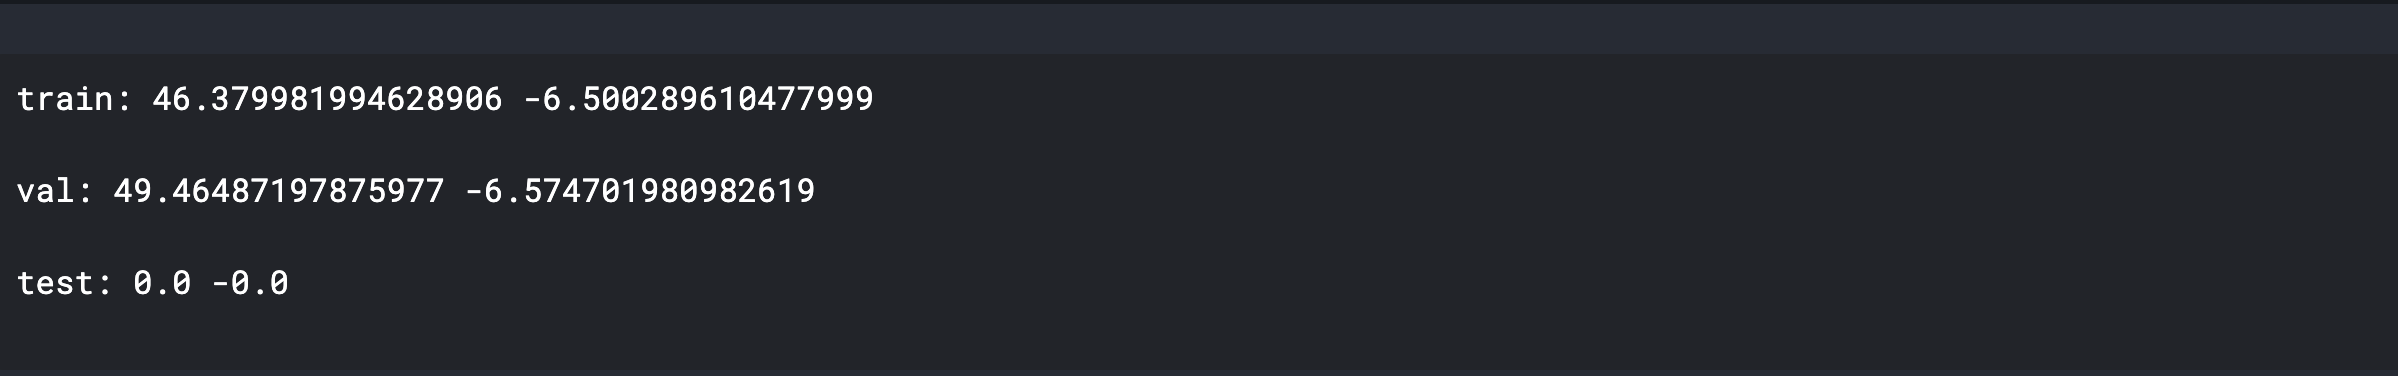

In [ ]:
# def plot_model(model_history, starting_point, metric):
plot_model(history.history, EPOCHS, 'score' )

In [ ]:
plt.figure(figsize=(14,10))
plt.title("Metric")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.plot(abs(y-pred[:,1]),color='red')
plt.plot(abs(pred[:,0]-pred[:,2]),color='blue')

In [ ]:
if TESTSIZE > 0:
    plt.figure(figsize=(14,10))
    plt.title("Metric")
    plt.xlabel("Epoch")
    plt.ylabel("Metric")
    plt.plot(abs(y_test-pred_test[:,1]),color='red')
    plt.plot(abs(pred_test[:,0]-pred_test[:,2]),color='blue')

In [ ]:
z.shape, y.shape, pred.shape
try:
    print(z.shape, y.shape, pred.shape, pred_test.shape)
except:
    print(z.shape, y.shape, pred.shape)

In [ ]:
#pred_test

In [ ]:

if GROUPS:
    for BIAS in (1,0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2):
        print('\nBIAS:',BIAS,'\n')
        laplace_Group_model('training',z,y,pred, BIAS)
        print('\nx--------x\n')
        if TESTSIZE > 0: laplace_Group_model('test',z_test,y_test,pred_test, BIAS)
else:
    laplace_model('training',z,y,pred)
    print('\nx--------x\n')
    if TESTSIZE > 0: laplace_model('test',z_test,y_test,pred_test)

In [ ]:
#predxs = net.predict(z, batch_size=BATCH_SIZE, verbose=0) #calcolato sull'ultimo fold
predxs = pred
idxs = np.random.randint(0, y.shape[0], 100)
idxs = np.sort(idxs)

In [ ]:
LOW_CORRECTION = tf.constant(1.0, dtype='float32') # per correggere la Confidenc
HIGH_CORRECTION = tf.constant(1.0, dtype='float32') 

plt.figure(figsize=(14,6))
plt.plot(y[idxs], label="ground truth")
plt.plot(predxs[idxs, 0] * LOW_CORRECTION, label="q20")
plt.plot(predxs[idxs, 1], label="q50")
plt.plot(predxs[idxs, 2] * HIGH_CORRECTION, label="q80")
plt.legend(loc="best")
plt.show()


In [ ]:
if TESTSIZE > 0:
    #predxs = net.predict(z_test, batch_size=BATCH_SIZE, verbose=0) #calcolato sull'ultimo fold
    predxs = pred_test
    idxs = np.random.randint(0, y_test.shape[0], 100)
    idxs = np.sort(idxs)
    plt.figure(figsize=(14,6))
    plt.plot(y_test[idxs], label="ground truth")
    plt.plot(predxs[idxs, 0] * LOW_CORRECTION, label="q20")
    plt.plot(predxs[idxs, 1], label="q50")
    plt.plot(predxs[idxs, 2] * HIGH_CORRECTION, label="q80")
    plt.legend(loc="best")
    plt.show()

In [ ]:
sigma_opt = mean_absolute_error(y, pred[:, 1])
unc = pred[:,2] - pred[:, 0]
sigma_mean = np.mean(unc)
print('sigma_opt mean_absolute_error(y, pred[:, 1]):',sigma_opt, 
      '\nsigma_mean np.mean(unc) unc = pred[:,2] - pred[:, 0]:',sigma_mean)

In [ ]:
plt.hist(unc)
plt.title("uncertainty in prediction")
plt.show()

In [ ]:
CORRECTION = tf.constant(1.0, dtype='float32') 

In [ ]:
sab = sub.copy()

In [ ]:

#pe = net.predict(ze, batch_size=BATCH_SIZE, verbose=0) #calcolato sull'ultimo fold

sab['FVC1'] = pe[:, 1]
sab['Confidence1'] = (pe[:, 2] - pe[:, 0]) #* CORRECTION #devo capire perché utilizzare questa

In [ ]:
CORRECTION

In [ ]:
d21 = pe[:,2]-pe[:,1]
d10 = pe[:,1]-pe[:,0]
d20 = pe[:,2]-pe[:,0]
dcorrect = (pe[:,2] - pe[:,0]) * CORRECTION
g = {'2-1':d21,'1-0':d10,'2-0':d20,'2-0 corr':dcorrect}
g = pd.DataFrame(data=g)
g.describe().T

In [ ]:
subm = sab[['Patient_Week','FVC','Confidence','FVC1','Confidence1']].copy()
subm.loc[~subm.FVC1.isnull(),'FVC'] = subm.loc[~subm.FVC1.isnull(),'FVC1']
subm.loc[~subm.FVC1.isnull(),'Confidence'] = abs(subm.loc[~subm.FVC1.isnull(),'Confidence1'])

subm.describe().T

In [ ]:
if sigma_mean<70:
    subm['Confidence'] = sigma_opt
else:
    subm.loc[~subm.FVC1.isnull(),'Confidence'] = subm.loc[~subm.FVC1.isnull(),'Confidence1']

subm.describe().T

In [ ]:
otest = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')
for i in range(len(otest)):
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'FVC'] = otest.FVC[i]
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'Confidence'] = 0.1


In [ ]:
subm[["Patient_Week","FVC","Confidence"]].to_csv("submission.csv", index=False)
print('Saved',GROUPS)

In [ ]:
#import sys 
#sys.exit()